In [91]:
import pandas as pd
import numpy as np
from modules.feature_modeling   import read_data_sample
from modules.utility_functions  import create_wordcloud
from modules.feature_modeling   import cosine_similarity_cal
from modules.feature_modeling   import process_main_features
from modules.feature_modeling   import additional_cleaning_books
from modules.feature_modeling   import prepare_corpus
from modules.feature_modeling   import cosine_recommendations
from modules.feature_modeling   import get_recommendation
from modules.feature_modeling   import compare_algorithm
from modules.sentiment_google   import tokenize_and_lemmatize
from modules.sentiment_google   import sentiment_analysis
from modules.sentiment_google   import add_data_sentiment
from modules.sentiment_google   import get_final_data
from modules.sentiment_google   import get_google_link
from modules.sentiment_google   import format_output_table
from modules.sentiment_google   import clickable
from modules.sentiment_google   import show_cover
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_theme(style='darkgrid', context='talk')

In [2]:
df_books_sample, df_authors_sample, df_reviews_sample, df_genres_sample = read_data_sample()

In [3]:
df_books_sample.shape

(23382, 13)

In [4]:
df_authors_sample.shape

(16057, 2)

In [5]:
df_reviews_sample.shape

(523874, 8)

In [6]:
df_genres_sample.head()

,book_id,genres
0,1,thriller
1,1,young-adult
2,1,fiction
3,1,fantasy
4,1,paranormal


In [9]:
df_genres = df_genres_sample.groupby('book_id')['genres'].agg(' '.join).reset_index()
df_genres.head()

,book_id,genres
0,1,thriller young-adult fiction fantasy paranorma...
1,6,romance fantasy paranormal fiction young-adult...
2,27,historical fiction biography fiction history n...
3,214,fiction history historical fiction mystery bio...
4,409,fantasy biography paranormal historical fictio...


In [10]:
df_books_sample.shape

(23382, 13)

In [11]:
df_books_sample_tmp = pd.merge(df_books_sample,df_genres, on='book_id', how='left')


In [12]:
df_books_sample_tmp.head()

,text_reviews_count,average_rating,description,num_pages,publication_year,image_url,book_id,ratings_count,title,title_without_series,author,name,description_text_clean,genres
0,27,3.33,A love story about a girl who comes back from ...,208,2015,https://images.gr-assets.com/books/1415581655m...,22965343,52,Who Is Mackie Spence?,Who Is Mackie Spence?,8456833,Lin Kaymer,"['love', 'story', 'girl', 'come', 'back', 'nea...",young-adult romance paranormal fantasy
1,10,3.83,Military service was once taken for granted as...,256,2006,https://s.gr-assets.com/assets/nophoto/book/11...,80118,72,AWOL: The Unexcused Absence of America's Upper...,AWOL: The Unexcused Absence of America's Upper...,45600,Kathy Roth-Douquet,"['military', 'service', 'taken', 'granted', 'n...",non-fiction history historical fiction biography
2,61,3.95,"Raenef is the black sheep of the demon court, ...",192,2003,https://images.gr-assets.com/books/1288648957m...,29497,4399,"Demon Diary, Volume 01","Demon Diary, Volume 01",16589,Kara,"['raenef', 'black', 'sheep', 'demon', 'court',...",paranormal graphic comics young-adult fantasy ...
3,207,4.02,"Set in South Carolina in 1964, The Secret Life...",333,2003,https://images.gr-assets.com/books/1444392146m...,6081433,3607,The Secret Life of Bees,The Secret Life of Bees,4711,Sue Monk Kidd,"['set', 'south', 'carolina', 'secret', 'life',...",historical fiction young-adult biography ficti...
4,6,4.09,Cathy Cramer is a former lawyer and investigat...,305,2013,https://images.gr-assets.com/books/1356054466m...,16182612,47,Truth Stained Lies,Truth Stained Lies,19811,Terri Blackstock,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",thriller mystery fiction crime romance


In [13]:
df_test_books = df_books_sample_tmp.loc[df_books_sample_tmp['name'].isin(['Patricia Davids'])]
df_test_books['title'].head(20)

14341         An Amish Noel (The Amish Bachelors, #2)
22162    A Matter of the Heart (Homecoming Heroes #4)
Name: title, dtype: object

In [14]:
version = 'A'
df_books_final = process_main_features(df_books_sample_tmp,version)
df_books_final.head()

,title,author,author_name,genres,description_text_clean,num_pages,keywords
0,Who Is Mackie Spence?,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt..."
1,AWOL: The Unexcused Absence of America's Upper...,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin..."
2,"Demon Diary, Volume 01",16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl..."
3,The Secret Life of Bees,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,..."
4,Truth Stained Lies,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ..."


In [22]:
df_books_final.to_csv('../data/sample_data/processed/books_final.csv', index=False)

In [15]:
#Version with book_id
version = 'B'
df_books_final_book_id= process_main_features(df_books_sample_tmp,version)
df_books_final_book_id.head()

,book_id,title,author,author_name,genres,description_text_clean,num_pages,keywords
0,22965343,Who Is Mackie Spence?,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt..."
1,80118,AWOL: The Unexcused Absence of America's Upper...,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin..."
2,29497,"Demon Diary, Volume 01",16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl..."
3,6081433,The Secret Life of Bees,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,..."
4,16182612,Truth Stained Lies,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ..."


In [17]:
df_books_final_book_id = additional_cleaning_books(df_books_final_book_id)

In [18]:
df_books_final_book_id.head()

,book_id,author,author_name,genres,description_text_clean,num_pages,keywords,title
0,22965343,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt...",Who Is Mackie Spence?
1,80118,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin...",AWOL: The Unexcused Absence of America's Upper...
2,29497,16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl...","Demon Diary, Volume 01"
3,6081433,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,...",The Secret Life of Bees
4,16182612,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ...",Truth Stained Lies


In [19]:
df_books_final_book_id.to_csv('../data/sample_data/processed/books_final_book_id.csv', index=False)

In [50]:
df_books_final_book_id = pd.read_csv('../data/sample_data/processed/books_final_book_id.csv',converters={'column': str.strip})

In [13]:
df_books_final = pd.read_csv('../data/sample_data/processed/books_final.csv',converters={'column': str.strip})
df_books_final.head()

,title,author,author_name,genres,description_text_clean,num_pages,keywords
0,Who Is Mackie Spence?,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"towneven, even, childhood, happening, injured,..."
1,AWOL: The Unexcused Absence of America's Upper...,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"good, someone, book, husband, people, voice, o..."
2,"Demon Diary, Volume 01",16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"terra lord, eclipse, demon, also, includes, se..."
3,The Secret Life of Bees,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"afternoon, deepest, sister, female, come town,..."
4,Truth Stained Lies,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"save, sister, killer, juliet, like, commentary..."


In [21]:
df_books_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23382 entries, 0 to 23381
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   23382 non-null  object
 1   author                  23382 non-null  int64 
 2   author_name             23382 non-null  object
 3   genres                  23248 non-null  object
 4   description_text_clean  23382 non-null  object
 5   num_pages               23382 non-null  int64 
 6   keywords                23382 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.2+ MB


In [22]:
df_books_final = prepare_corpus(df_books_final)

In [23]:
df_books_final.head()

,title,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title_clean
0,Who Is Mackie Spence?,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt...",young-adult romance paranormal fantasy somethi...,Who Is Mackie Spence?
1,AWOL: The Unexcused Absence of America's Upper...,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin...",non-fiction history historical fiction biograp...,AWOL: The Unexcused Absence of America's Upper...
2,"Demon Diary, Volume 01",16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl...",paranormal graphic comics young-adult fantasy ...,"Demon Diary, Volume 01"
3,The Secret Life of Bees,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,...",historical fiction young-adult biography ficti...,The Secret Life of Bees
4,Truth Stained Lies,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ...","thriller mystery fiction crime romance drive, ...",Truth Stained Lies


In [24]:
df_test_books = df_books_final.loc[df_books_final['author_name'].isin(['Stephen King','J.K. Rowling'])]
df_test_books.head()

,title,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title_clean
126,Harry Potter and the Sorcerer's Stone (Harry P...,1077326,J.K. Rowling,crime thriller mystery children paranormal fic...,"['harry', 'potter', 'idea', 'famous', 'thats',...",422,"famous, parent, unusual, unique, clue, attend,...",crime thriller mystery children paranormal fic...,Harry Potter and the Sorcerer's Stone (Harry P...
1069,Dolores Claiborne,3389,Stephen King,crime mystery thriller fiction fantasy paranormal,"['thirty', 'year', 'folk', 'little', 'tall', '...",372,"love, claibornes, care, claiborne, eclipse, ee...",crime mystery thriller fiction fantasy paranor...,Dolores Claiborne
1234,Harry Potter and the Prisoner of Azkaban (Harr...,1077326,J.K. Rowling,fantasy mystery crime thriller paranormal youn...,"['twelve', 'long', 'year', 'dread', 'fortress'...",468,"sleep, named, youknowwho, hogwarts, voldemort,...",fantasy mystery crime thriller paranormal youn...,Harry Potter and the Prisoner of Azkaban (Harr...
1269,Pottermore Presents (3 Book Series),1077326,J.K. Rowling,paranormal fiction young-adult fantasy childre...,"['book', 'minerva', 'roman', 'goddess', 'warri...",218,"something, pottermorecom, ebooks, remus, addit...",paranormal fiction young-adult fantasy childre...,Pottermore Presents (3 Book Series)
1647,It,3389,Stephen King,crime thriller mystery fiction fantasy paranormal,"['small', 'city', 'place', 'hauntingly', 'fami...",1090,"gain, stumbled, end, derry, success, none, men...",crime thriller mystery fiction fantasy paranor...,It


In [25]:
df_test_books = df_books_final.loc[df_books_final['author_name'].isin(['Patricia Davids'])]
df_test_books.head()

,title,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title_clean
14341,"An Amish Noel (The Amish Bachelors, #2)",175873,Patricia Davids,fiction romance,"['amish', 'homecoming', 'luke', 'bowman', 'hom...",288,"material, homecoming, good, committed, communi...","fiction romance material, homecoming, good, co...","An Amish Noel (The Amish Bachelors, #2)"
22162,A Matter of the Heart (Homecoming Heroes #4),175873,Patricia Davids,fiction romance,"['operating', 'sick', 'little', 'boy', 'dr', '...",214,"yes care, robs, granted, young, blake, profit,...","fiction romance yes care, robs, granted, young...",A Matter of the Heart (Homecoming Heroes #4)


In [26]:
#Based on keywords
column_funtion = ('keywords')
df_cosine_sim,cosine_sim = cosine_similarity_cal(df_books_final, column_funtion)

In [92]:
#save similarity score
pickle.dump(cosine_sim,open("../output/similarity_score_keywords.pkl","wb"))

In [27]:
df_cosine_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,23372,23373,23374,23375,23376,23377,23378,23379,23380,23381
0,1.000000,0.056997,0.022695,0.011746,0.029198,0.009712,0.033607,0.042949,0.020234,0.060110,...,0.017849,0.028482,0.011252,0.005614,0.000000,0.011651,0.038718,0.005419,0.029840,0.034830
1,0.056997,1.000000,0.021693,0.012661,0.037434,0.018833,0.028611,0.019237,0.027933,0.042912,...,0.012098,0.035295,0.003030,0.014044,0.000000,0.010855,0.028334,0.004437,0.019204,0.018779
2,0.022695,0.021693,1.000000,0.014654,0.007580,0.003962,0.023252,0.015328,0.018232,0.018055,...,0.039224,0.028688,0.000000,0.011815,0.000000,0.030041,0.017423,0.007648,0.000000,0.043089
3,0.011746,0.012661,0.014654,1.000000,0.016636,0.013509,0.025272,0.040340,0.005256,0.023232,...,0.015847,0.023318,0.006067,0.024956,0.000000,0.021210,0.025330,0.004055,0.011323,0.002486
4,0.029198,0.037434,0.007580,0.016636,1.000000,0.000000,0.008299,0.017829,0.009288,0.029830,...,0.015634,0.018893,0.000000,0.004827,0.004322,0.021123,0.000000,0.000000,0.000000,0.014548


In [28]:
df_reviews_sample.head()

,user_id,book_id,review_id,rating,review_text,n_votes,n_comments,review_text_clean
0,8842281e1d1347389f2ab93d60773d4d,20873740,ef77b0cd7d5db0a85aa64f291d63d450,5,"I haven't read a ton of ""history of the world""...",68,5,"['havent', 'read', 'ton', 'history', 'world', ..."
1,8842281e1d1347389f2ab93d60773d4d,23310161,f4b4b050f4be00e9283c92a814af2670,4,Fun sequel to the original.,7,0,"['fun', 'sequel', 'original.']"
2,8842281e1d1347389f2ab93d60773d4d,12953520,8666dfd554e310084c4bc72b2d357f3d,4,A hilarious romp through the known and unknown...,1,0,"['hilarious', 'romp', 'known', 'unknown', 'uni..."
3,8842281e1d1347389f2ab93d60773d4d,77430,28007503b429dc6724da7076ae7306b4,5,One of the most enjoyable stories I've read in...,5,0,"['one', 'enjoyable', 'story', 'ive', 'read', '..."
4,8842281e1d1347389f2ab93d60773d4d,1953,70c420b9b26d869a1ef8548b20a9edeb,4,On loan to Diana Sonn,2,0,"['loan', 'diana', 'sonn']"


#### Recommenders

In [29]:
#Prepare data for recommender
titles = df_books_final['title_clean']
indices = pd.Series(df_books_final.index, index=df_books_final['title_clean'])

In [30]:
#Get recommendations based on keywords cosine
cosine_recommendations('Dolores Claiborne',titles,indices,cosine_sim).head(10)

8225     The Rocker Who Holds Me (The Rocker, #1)
11714                    Evil Eye (Special X, #5)
12242                           The Roanoke Girls
2023                           Patriots Awakening
7427                                Skeleton Crew
191                                Darkness Wakes
7377             Fern Verdant and the Silver Rose
3877                               Blood Marriage
16963               Sparrow Man (Sparrow Man, #1)
1386                                     The Doll
Name: title_clean, dtype: object

In [31]:
#Calculate cosine of similarity with corpus
column_funtion = ('corpus')
df_cosine_sim,cosine_sim_c = cosine_similarity_cal(df_books_final, column_funtion)

In [93]:
#save similarity score
pickle.dump(cosine_sim_c,open('../output/similarity_score_corpus.pkl',"wb"))

In [32]:
#Prepare data for recommender based on the corpus
titles = df_books_final['title']
title_ind = pd.Series(df_books_final.index, index=df_books_final['title'])

In [33]:
#Get recommendations based on corpus cosine
cosine_recommendations('Dolores Claiborne',titles,title_ind,cosine_sim_c).head(10)

191                                Darkness Wakes
7427                                Skeleton Crew
11714                   Evil Eye  (Special X, #5)
8225     The Rocker Who Holds Me (The Rocker, #1)
3877                               Blood Marriage
2023                           Patriots Awakening
1386                                     The Doll
7377             Fern Verdant and the Silver Rose
7638                        Numbers (Numbers, #1)
10598                                        Cujo
Name: title, dtype: object

In [34]:
import surprise
from sklearn.cluster import KMeans
from kneed import KneeLocator
import spacy
from IPython.display import clear_output


In [47]:
n_k = range(1, 41)
nlp = spacy.load("en_core_web_sm")
sse = []
kmeans_params = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}
for k in n_k:
    print(f'Cluster {k}/40')
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(cosine_sim)
    sse.append(kmeans.inertia_)
    clear_output(wait=True)
locator = KneeLocator(n_k, sse, curve='convex', direction='decreasing')
print('Best cluster for KMeans:', locator.elbow)

Best cluster for KMeans: 8


In [48]:
kmeans = KMeans(n_clusters=locator.elbow, **kmeans_params)
kmeans.fit(cosine_sim)


KMeans(init='random', n_init=10, random_state=42)

In [39]:
kmeans = KMeans(n_clusters=8, init='random', n_init=10, random_state=42)
kmeans.fit(cosine_sim)

KMeans(init='random', n_init=10, random_state=42)

In [40]:
df_books_final['cluster'] = kmeans.labels_


In [127]:
n_k2 = range(1,9)
nlp2 = spacy.load("en_core_web_sm")
sse2 = []
kmeans_params = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 30,
    'random_state': 1
}
for k in n_k2:
    print(f'Cluster {k}/9')
    kmeans2 = KMeans(n_clusters=k, **kmeans_params)
    kmeans2.fit(cosine_sim_c)
    sse2.append(kmeans2.inertia_)
    clear_output(wait=True)
locator2 = KneeLocator(n_k2, sse2, curve='convex', direction='decreasing')
print('Best cluster for KMeans:', locator2.elbow)

Best cluster for KMeans: 3


In [128]:
kmeans2 = KMeans(n_clusters=locator2.elbow, **kmeans_params)
kmeans2.fit(cosine_sim_c)

KMeans(init='random', max_iter=30, n_clusters=3, n_init=10, random_state=1)

In [41]:
kmeans2 = KMeans(n_clusters=3, max_iter=30,init='random', n_init=10, random_state=1)
kmeans2.fit(cosine_sim_c)

KMeans(init='random', max_iter=30, n_clusters=3, n_init=10, random_state=1)

In [42]:
df_books_final['cluster2'] = kmeans2.labels_

In [43]:
df_books_final.head()

,title,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title_clean,cluster,cluster2
0,Who Is Mackie Spence?,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt...",young-adult romance paranormal fantasy somethi...,Who Is Mackie Spence?,4,1
1,AWOL: The Unexcused Absence of America's Upper...,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin...",non-fiction history historical fiction biograp...,AWOL: The Unexcused Absence of America's Upper...,3,2
2,"Demon Diary, Volume 01",16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl...",paranormal graphic comics young-adult fantasy ...,"Demon Diary, Volume 01",5,1
3,The Secret Life of Bees,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,...",historical fiction young-adult biography ficti...,The Secret Life of Bees,5,2
4,Truth Stained Lies,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ...","thriller mystery fiction crime romance drive, ...",Truth Stained Lies,5,0


In [44]:
df_books_final.drop(columns=['title'], inplace=True)

In [45]:
df_books_final = df_books_final.rename(columns={'title_clean':'title'})
df_books_final.head()

,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title,cluster,cluster2
0,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt...",young-adult romance paranormal fantasy somethi...,Who Is Mackie Spence?,4,1
1,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin...",non-fiction history historical fiction biograp...,AWOL: The Unexcused Absence of America's Upper...,3,2
2,16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl...",paranormal graphic comics young-adult fantasy ...,"Demon Diary, Volume 01",5,1
3,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,...",historical fiction young-adult biography ficti...,The Secret Life of Bees,5,2
4,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ...","thriller mystery fiction crime romance drive, ...",Truth Stained Lies,5,0


In [94]:
#save books with clusters
pickle.dump(df_books_final,open('../output/books_clean_clusters.pkl',"wb"))

In [46]:
testing_book = df_books_final.sample(1, random_state=2400)#Dolores Claiborne
testing_book

,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title,cluster,cluster2
10370,13574731,Sacha Mardou,comics biography graphic fiction non-fiction h...,"['iris', 'young', 'woman', 'turning', 'eightee...",180,"film, fellow, position, missing, slowly, train...",comics biography graphic fiction non-fiction h...,Sky in Stereo,2,2


In [47]:
df_test_book = df_books_final.loc[df_books_final['title'].isin(['Dolores Claiborne'])]
df_test_book.head()

,author,author_name,genres,description_text_clean,num_pages,keywords,corpus,title,cluster,cluster2
1069,3389,Stephen King,crime mystery thriller fiction fantasy paranormal,"['thirty', 'year', 'folk', 'little', 'tall', '...",372,"love, claibornes, care, claiborne, eclipse, ee...",crime mystery thriller fiction fantasy paranor...,Dolores Claiborne,0,1


In [50]:
df_book_map = pd.Series(df_books_final.index, index=df_books_final['title'])
df_book_map.head()

title
Who Is Mackie Spence?                                                                                           0
AWOL: The Unexcused Absence of America's Upper Classes from Military Service -- and How It Hurts Our Country    1
Demon Diary, Volume 01                                                                                          2
The Secret Life of Bees                                                                                         3
Truth Stained Lies                                                                                              4
dtype: int64

In [51]:
#Prepare data for book recommendation function
test_title = df_test_book['title'].values[0]
df_test = df_books_final[['title', 'author', 'genres', 'cluster']].loc[df_books_final['title'] == test_title]
df_test['genres'] = df_test['genres'].apply(lambda x: x.split())
df_test.head()

,title,author,genres,cluster
1069,Dolores Claiborne,3389,"[crime, mystery, thriller, fiction, fantasy, p...",0


In [52]:
#Using Keywords
recommended_books = get_recommendation(test_title,cosine_sim,df_book_map,df_books_final)
recommended_books

,title,author_name,genres,score
8225,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,"[young-adult, fiction, romance]",0.086273
11714,"Evil Eye (Special X, #5)",Michael Slade,"[mystery, fiction, crime, thriller]",0.078572
12242,The Roanoke Girls,Amy Engel,"[fiction, young-adult, crime, mystery, thriller]",0.078220
2023,Patriots Awakening,R.M. Strauhs,"[crime, mystery, thriller, fiction]",0.076133
7427,Skeleton Crew,Stephen King,"[fantasy, paranormal, mystery, fiction, crime,...",0.075098
191,Darkness Wakes,Tim Waggoner,"[thriller, fiction, paranormal, fantasy, crime...",0.074790
7377,Fern Verdant and the Silver Rose,Diana Leszczynski,"[children, crime, fantasy, thriller, fiction, ...",0.074587
3877,Blood Marriage,Regina Richards,"[thriller, paranormal, crime, romance, mystery...",0.073905
16963,"Sparrow Man (Sparrow Man, #1)",M.R. Pritchard,"[fiction, thriller, crime, mystery, fantasy, p...",0.073673
1386,The Doll,J.C. Martin,"[paranormal, thriller, fantasy, crime, fiction...",0.072874


In [53]:
recommended_books['cluster'] = recommended_books['title'].apply(
    lambda x: df_books_final.loc[df_books_final['title'] == x, 'cluster'].values[0] \
    if x in df_books_final['title'].values.tolist() else False)
recommended_books

,title,author_name,genres,score,cluster
8225,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,"[young-adult, fiction, romance]",0.086273,4
11714,"Evil Eye (Special X, #5)",Michael Slade,"[mystery, fiction, crime, thriller]",0.078572,5
12242,The Roanoke Girls,Amy Engel,"[fiction, young-adult, crime, mystery, thriller]",0.078220,4
2023,Patriots Awakening,R.M. Strauhs,"[crime, mystery, thriller, fiction]",0.076133,3
7427,Skeleton Crew,Stephen King,"[fantasy, paranormal, mystery, fiction, crime,...",0.075098,5
191,Darkness Wakes,Tim Waggoner,"[thriller, fiction, paranormal, fantasy, crime...",0.074790,3
7377,Fern Verdant and the Silver Rose,Diana Leszczynski,"[children, crime, fantasy, thriller, fiction, ...",0.074587,0
3877,Blood Marriage,Regina Richards,"[thriller, paranormal, crime, romance, mystery...",0.073905,4
16963,"Sparrow Man (Sparrow Man, #1)",M.R. Pritchard,"[fiction, thriller, crime, mystery, fantasy, p...",0.073673,4
1386,The Doll,J.C. Martin,"[paranormal, thriller, fantasy, crime, fiction...",0.072874,2


In [54]:
#Using the corpus
recommended_books2 = get_recommendation(test_title,cosine_sim_c,df_book_map,df_books_final)
recommended_books2

,title,author_name,genres,score
191,Darkness Wakes,Tim Waggoner,"[thriller, fiction, paranormal, fantasy, crime...",0.087603
7427,Skeleton Crew,Stephen King,"[fantasy, paranormal, mystery, fiction, crime,...",0.087231
11714,"Evil Eye (Special X, #5)",Michael Slade,"[mystery, fiction, crime, thriller]",0.086258
8225,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,"[young-adult, fiction, romance]",0.086181
3877,Blood Marriage,Regina Richards,"[thriller, paranormal, crime, romance, mystery...",0.085603
2023,Patriots Awakening,R.M. Strauhs,"[crime, mystery, thriller, fiction]",0.085327
1386,The Doll,J.C. Martin,"[paranormal, thriller, fantasy, crime, fiction...",0.085207
7377,Fern Verdant and the Silver Rose,Diana Leszczynski,"[children, crime, fantasy, thriller, fiction, ...",0.084811
7638,"Numbers (Numbers, #1)",Rachel Ward,"[paranormal, mystery, romance, thriller, crime...",0.082886
10598,Cujo,Stephen King,"[fiction, mystery, thriller, crime, paranormal...",0.082862


In [55]:
recommended_books2['cluster2'] = recommended_books2['title'].apply(
    lambda x: df_books_final.loc[df_books_final['title'] == x, 'cluster'].values[0] \
    if x in df_books_final['title'].values.tolist() else False)
recommended_books2

,title,author_name,genres,score,cluster2
191,Darkness Wakes,Tim Waggoner,"[thriller, fiction, paranormal, fantasy, crime...",0.087603,3
7427,Skeleton Crew,Stephen King,"[fantasy, paranormal, mystery, fiction, crime,...",0.087231,5
11714,"Evil Eye (Special X, #5)",Michael Slade,"[mystery, fiction, crime, thriller]",0.086258,5
8225,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,"[young-adult, fiction, romance]",0.086181,4
3877,Blood Marriage,Regina Richards,"[thriller, paranormal, crime, romance, mystery...",0.085603,4
2023,Patriots Awakening,R.M. Strauhs,"[crime, mystery, thriller, fiction]",0.085327,3
1386,The Doll,J.C. Martin,"[paranormal, thriller, fantasy, crime, fiction...",0.085207,2
7377,Fern Verdant and the Silver Rose,Diana Leszczynski,"[children, crime, fantasy, thriller, fiction, ...",0.084811,0
7638,"Numbers (Numbers, #1)",Rachel Ward,"[paranormal, mystery, romance, thriller, crime...",0.082886,4
10598,Cujo,Stephen King,"[fiction, mystery, thriller, crime, paranormal...",0.082862,2


In [56]:
df_reviews_sample.head()

,user_id,book_id,review_id,rating,review_text,n_votes,n_comments,review_text_clean
0,8842281e1d1347389f2ab93d60773d4d,20873740,ef77b0cd7d5db0a85aa64f291d63d450,5,"I haven't read a ton of ""history of the world""...",68,5,"['havent', 'read', 'ton', 'history', 'world', ..."
1,8842281e1d1347389f2ab93d60773d4d,23310161,f4b4b050f4be00e9283c92a814af2670,4,Fun sequel to the original.,7,0,"['fun', 'sequel', 'original.']"
2,8842281e1d1347389f2ab93d60773d4d,12953520,8666dfd554e310084c4bc72b2d357f3d,4,A hilarious romp through the known and unknown...,1,0,"['hilarious', 'romp', 'known', 'unknown', 'uni..."
3,8842281e1d1347389f2ab93d60773d4d,77430,28007503b429dc6724da7076ae7306b4,5,One of the most enjoyable stories I've read in...,5,0,"['one', 'enjoyable', 'story', 'ive', 'read', '..."
4,8842281e1d1347389f2ab93d60773d4d,1953,70c420b9b26d869a1ef8548b20a9edeb,4,On loan to Diana Sonn,2,0,"['loan', 'diana', 'sonn']"


Recommender with surprise

In [57]:
#Get upper and lower rating
lower_rating = df_reviews_sample['rating'].min()
upper_rating = df_reviews_sample['rating'].max()
print('Review range: {0} to {1}'.format(lower_rating,upper_rating))

Review range: 0 to 5


In [58]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_reviews_sample[['user_id', 'book_id', 'rating']], reader)

In [59]:
df_surprise_results = compare_algorithm(data)

In [60]:
df_surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.140892,3.002502,0.766609
SVDpp,1.144361,3.716747,1.960644
NMF,1.305781,8.601673,0.805924


In [61]:
df_books_final_book_id.head()

,book_id,author,author_name,genres,description_text_clean,num_pages,keywords,title
0,22965343,8456833,Lin Kaymer,young-adult romance paranormal fantasy,"['love', 'story', 'girl', 'come', 'back', 'nea...",208,"something, though, night, neardrowning, doesnt...",Who Is Mackie Spence?
1,80118,45600,Kathy Roth-Douquet,non-fiction history historical fiction biography,"['military', 'service', 'taken', 'granted', 'n...",256,"research, firsthand, officer, widens, includin...",AWOL: The Unexcused Absence of America's Upper...
2,29497,16589,Kara,paranormal graphic comics young-adult fantasy ...,"['raenef', 'black', 'sheep', 'demon', 'court',...",192,"master, discovery, eclipse, claim, tutor, incl...","Demon Diary, Volume 01"
3,6081433,4711,Sue Monk Kidd,historical fiction young-adult biography ficti...,"['set', 'south', 'carolina', 'secret', 'life',...",333,"shaped, south, afternoon, lily, fiercehearted,...",The Secret Life of Bees
4,16182612,19811,Terri Blackstock,thriller mystery fiction crime romance,"['cathy', 'cramer', 'former', 'lawyer', 'inves...",305,"drive, conviction, cathy, cramer, field, put, ...",Truth Stained Lies


In [62]:
rating_books_tmp = df_reviews_sample[['user_id', 'book_id', 'rating']]
books_main_tmp = df_books_final_book_id[['book_id','title']]

In [63]:
rating_books = pd.merge(rating_books_tmp, books_main_tmp, on='book_id', how='inner')

In [64]:
rating_books.shape

(523874, 4)

In [65]:
df_user_ratings = rating_books[rating_books['user_id'].map(rating_books['user_id'].value_counts())>50]#users with more than 50 reviews

df_user_ratings.shape

(27447, 4)

In [66]:
df_user_ratings.to_csv('../data/sample_data/processed/user_rating_50rplus.csv',index = False)

In [67]:
df_ratings = df_user_ratings.drop_duplicates(['user_id','book_id'])

In [68]:
df_ratings.shape

(27447, 4)

In [70]:
testing_ratings = df_ratings
testing_ratings.head()

,user_id,book_id,rating,title
53,d1e368a7d2870eb6fbf6e0d350568a2d,23310161,4,The Day the Crayons Came Home
57,5a7355dd76fb7649912b783dffe604e1,23310161,5,The Day the Crayons Came Home
58,2d83dd909c236f532cd423e26f85bcc9,23310161,3,The Day the Crayons Came Home
61,ff6d428e075e07702736c9d047b2c046,23310161,0,The Day the Crayons Came Home
66,9003d274774f4c47e62f77600b08ac1d,23310161,4,The Day the Crayons Came Home


In [71]:
books_matrix = testing_ratings.pivot_table(index = 'user_id', columns = 'title', values = 'rating').fillna(0)
books_matrix.shape

(356, 9066)

In [72]:
X = books_matrix.values.T
X.shape

(9066, 356)

In [73]:
#Fitting the Model
SVD = TruncatedSVD(n_components=12, random_state=0)
matrix = SVD.fit_transform(X)
matrix.shape #(9066, 12)

(9066, 12)

In [119]:
import pickle

# save
with open('../output/model_SVD.pkl','wb') as f:
    pickle.dump(matrix,f)

In [ ]:
# load
with open('../output/model_SVD.pkl', 'rb') as f:
    matrix = pickle.load(f)

In [74]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)#to avoid RuntimeWarning warnings about runtime
corr = np.corrcoef(matrix)
corr.shape

(9066, 9066)

In [75]:
title = books_matrix.columns
title_list = list(title)


In [76]:
search_val = title_list.index('Doctor Sleep')#Doctor Sleep #One More Day
corr_search_val  = corr[search_val]


In [77]:
print(search_val)

2012


In [78]:
results = list(title[(corr_search_val >= 0.9)])

In [79]:
df_results = pd.DataFrame(results)

In [80]:
df_results.columns = ['title']
df_results.head(20)

,title
0,1491: New Revelations of the Americas Before C...
1,1984
2,"77 Shadow Street (Pendleton, #1)"
3,A Covert Affair: Julia Child and Paul Child in...
4,A Fortunate Life
5,A Hippo Banquet
6,A History of the Arab Peoples
7,A Memoir
8,A Spy Among Friends: Kim Philby and the Great ...
9,A Thousand Years of Nonlinear History


In [ ]:
list(title[(corr_search_val >= 0.9)])

In [81]:
df_test_rating_results = testing_ratings.loc[testing_ratings['title'].isin(df_results['title'])]

In [82]:
df_test_rating_results.shape

(269, 4)

In [83]:
df_results_reviews = df_reviews_sample.loc[df_reviews_sample['book_id'].isin(df_test_rating_results['book_id'])]

In [84]:
df_results_reviews.head()

,user_id,book_id,review_id,rating,review_text,n_votes,n_comments,review_text_clean
111,e5a7b620c83ea9268e89013dba154c70,1480063,9ce4d35573a3a9736afbb1b9a88714d6,3,I would give this 3 1/2 stars. I don't know if...,0,0,"['would', 'give', 'stars.', 'dont', 'know', 'r..."
116,478f3accbbb16d817fd90732215b6391,16130549,bb96be367dbea64d6e09f24154cd0b1d,3,It pains me to give a Stephen King book only t...,0,0,"['pain', 'give', 'stephen', 'king', 'book', 't..."
151,0c5b36407771dfd65acdd812ecd51705,18736925,2f1b97bf7965508912c6738da1fc7446,5,The thing with heralded books on economic thou...,1,0,"['thing', 'heralded', 'book', 'economic', 'tho..."
232,1afe8b35c5e568e95bc17e5b5cdbfd1b,21412400,436422429c6b8b8cb15e225b48f77db6,3,I enjoyed this book but it was also very weird...,1,0,"['enjoyed', 'book', 'also', 'weird.', 'narrato..."
244,ced7b8e0a3340e8af27f2663f442c3bb,16130549,11a26c5c15f78b740faecf6eff5e15c1,3,I really enjoyed catching up with Danny Torran...,0,0,"['really', 'enjoyed', 'catching', 'danny', 'to..."


Sentiment analysis

In [85]:
df_results_reviews['review_clean'] = df_results_reviews['review_text'].astype(str).apply(tokenize_and_lemmatize)

/var/folders/4t/t4gffd517xs3n8dx_yhbc9g80000gn/T/ipykernel_1059/3246325635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_reviews['review_clean'] = df_results_reviews['review_text'].astype(str).apply(tokenize_and_lemmatize)


In [86]:
df_results_reviews.head()

,user_id,book_id,review_id,rating,review_text,n_votes,n_comments,review_text_clean,review_clean
111,e5a7b620c83ea9268e89013dba154c70,1480063,9ce4d35573a3a9736afbb1b9a88714d6,3,I would give this 3 1/2 stars. I don't know if...,0,0,"['would', 'give', 'stars.', 'dont', 'know', 'r...",would give star . dont know really bad time re...
116,478f3accbbb16d817fd90732215b6391,16130549,bb96be367dbea64d6e09f24154cd0b1d,3,It pains me to give a Stephen King book only t...,0,0,"['pain', 'give', 'stephen', 'king', 'book', 't...",pain give stephen king book three star . bear ...
151,0c5b36407771dfd65acdd812ecd51705,18736925,2f1b97bf7965508912c6738da1fc7446,5,The thing with heralded books on economic thou...,1,0,"['thing', 'heralded', 'book', 'economic', 'tho...",thing heralded book economic thought usually d...
232,1afe8b35c5e568e95bc17e5b5cdbfd1b,21412400,436422429c6b8b8cb15e225b48f77db6,3,I enjoyed this book but it was also very weird...,1,0,"['enjoyed', 'book', 'also', 'weird.', 'narrato...",enjoyed book also weird . narrator unreliable ...
244,ced7b8e0a3340e8af27f2663f442c3bb,16130549,11a26c5c15f78b740faecf6eff5e15c1,3,I really enjoyed catching up with Danny Torran...,0,0,"['really', 'enjoyed', 'catching', 'danny', 'to...",really enjoyed catching danny torrance like wa...


In [87]:
df_results_reviews = sentiment_analysis(df_results_reviews)


/Users/hugo/Library/CloudStorage/OneDrive-Personal/DATA_Science/Bootcamp/W11/books-recommendations/src/modules/sentiment_google.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['review_clean'].apply(sentiment_pipeline)
/Users/hugo/Library/CloudStorage/OneDrive-Personal/DATA_Science/Bootcamp/W11/books-recommendations/src/modules/sentiment_google.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_label'] = df['sentiment'].apply(lambda x: x[0]['label'])
/Users/hugo/Libr

,user_id,book_id,review_id,rating,review_text,n_votes,n_comments,review_text_clean,review_clean,sentiment,sentiment_label,sentiment_score
111,e5a7b620c83ea9268e89013dba154c70,1480063,9ce4d35573a3a9736afbb1b9a88714d6,3,I would give this 3 1/2 stars. I don't know if...,0,0,"['would', 'give', 'stars.', 'dont', 'know', 'r...",would give star . dont know really bad time re...,"[{'label': 'POSITIVE', 'score': 0.996178865432...",POSITIVE,0.996179


In [88]:
df_results_reviews.shape

(8033, 12)

In [95]:
pickle.dump(df_results_reviews,open('../output/result_reviews_sentiment.pkl',"wb"))

In [89]:
df_results_reviews.to_csv('../data/sample_data/processed/results_reviews_prep_sent.csv', index=False)

In [207]:
#df_results_reviews = pd.read_csv('../data/sample_data/processed/results_reviews_prep_sent.csv')

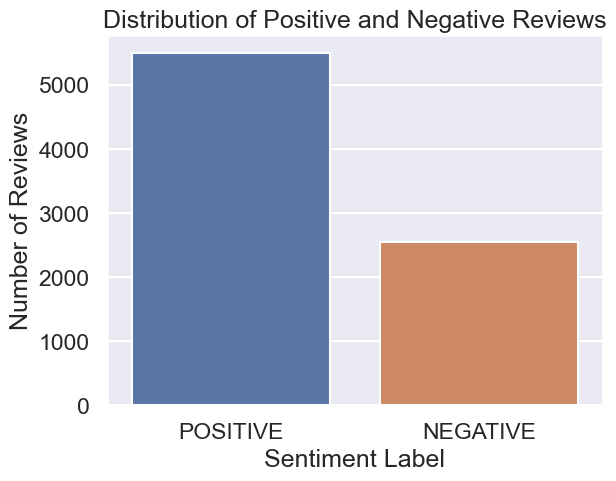

In [99]:
import seaborn as sns

# create a bar chart showing the number of positive and negative reviews
sns.countplot(x='sentiment_label', data=df_results_reviews)

# add labels to the chart
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.show()

In [100]:
#add data for sentiment amd calculate perentage by book based on reviews
pivot_table = add_data_sentiment(df_results_reviews)

In [101]:
print(pivot_table)

sentiment_label  NEGATIVE  POSITIVE  total_reviews  % positive  % negative
book_id                                                                   
3399                   23        92            115    0.800000    0.200000
4360                    7        13             20    0.650000    0.350000
4937                    9        17             26    0.653846    0.346154
6820                   63       118            181    0.651934    0.348066
8718                   11        25             36    0.694444    0.305556
...                   ...       ...            ...         ...         ...
28789688                3         2              5    0.400000    0.600000
29751398              103       189            292    0.647260    0.352740
29771631                1         1              2    0.500000    0.500000
30344295                1         4              5    0.800000    0.200000
31706250               45        85            130    0.653846    0.346154

[160 rows x 5 columns]


In [102]:
pickle.dump(pivot_table,open('../output/result_reviews_sentiment_pcts.pkl',"wb"))

In [240]:
pivot_table.to_csv("../data/sample_data/processed/sentiment_books_recommended.csv", index=False)

In [103]:
df_reviews_rec_sentiment = pivot_table.sort_values(by=['total_reviews'], ascending= False).head(20)
df_reviews_rec_sentiment

sentiment_label,NEGATIVE,POSITIVE,total_reviews,% positive,% negative
book_id,,,,,
16130549,642,1862,2504,0.743610,0.256390
21412400,134,317,451,0.702882,0.297118
23208397,111,267,378,0.706349,0.293651
11166890,193,178,371,0.479784,0.520216
15852479,90,245,335,0.731343,0.268657
29751398,103,189,292,0.647260,0.352740
12749,104,170,274,0.620438,0.379562
550844,62,161,223,0.721973,0.278027
6820,63,118,181,0.651934,0.348066


In [104]:
df_final_data = get_final_data(df_reviews_rec_sentiment,df_books_sample_tmp)

In [105]:
df_final_data

,book_id,NEGATIVE,POSITIVE,total_reviews,% positive,% negative,title,name,average_rating,image_url
0,16130549,642,1862,2504,0.743610,0.256390,Doctor Sleep,Stephen King,4.10,https://images.gr-assets.com/books/1510335480m...
1,21412400,134,317,451,0.702882,0.297118,The First Bad Man,Miranda July,3.58,https://images.gr-assets.com/books/1421037741m...
2,23208397,111,267,378,0.706349,0.293651,Underground Airlines,Ben H. Winters,3.87,https://images.gr-assets.com/books/1443732702m...
3,11166890,193,178,371,0.479784,0.520216,"77 Shadow Street (Pendleton, #1)",Dean Koontz,3.30,https://s.gr-assets.com/assets/nophoto/book/11...
4,15852479,90,245,335,0.731343,0.268657,We Need New Names,NoViolet Bulawayo,3.71,https://images.gr-assets.com/books/1352225506m...
5,29751398,103,189,292,0.647260,0.352740,The Power,Naomi Alderman,3.93,https://images.gr-assets.com/books/1462814013m...
6,12749,104,170,274,0.620438,0.379562,"Swann's Way (In Search of Lost Time, #1)",Marcel Proust,4.14,https://images.gr-assets.com/books/1452956236m...
7,550844,62,161,223,0.721973,0.278027,Cycle of the Werewolf,Stephen King,3.62,https://s.gr-assets.com/assets/nophoto/book/11...
8,6820,63,118,181,0.651934,0.348066,number9dream,David Mitchell,3.91,https://images.gr-assets.com/books/1320540682m...
9,6839917,81,93,174,0.534483,0.465517,So Much for That,Lionel Shriver,3.70,https://images.gr-assets.com/books/1262038014m...


In [265]:
#def make_clickable(val):
#    return '<a target="_blank" href="{}">Google Books Details</a>'.format(val, val)

#def show_image(val):
 #   return '<img src="{}" width=50></img>'.format(val)

In [106]:
index = df_final_data[df_final_data['title'] == 'Doctor Sleep'].index


In [107]:
df_final_data.drop(index, inplace=True)

In [108]:
df_final_data.head(10).style.format({'image_url': show_cover})

,book_id,NEGATIVE,POSITIVE,total_reviews,% positive,% negative,title,name,average_rating,image_url
1,21412400,134,317,451,0.702882,0.297118,The First Bad Man,Miranda July,3.580000,
2,23208397,111,267,378,0.706349,0.293651,Underground Airlines,Ben H. Winters,3.870000,
3,11166890,193,178,371,0.479784,0.520216,"77 Shadow Street (Pendleton, #1)",Dean Koontz,3.300000,
4,15852479,90,245,335,0.731343,0.268657,We Need New Names,NoViolet Bulawayo,3.710000,
5,29751398,103,189,292,0.647260,0.352740,The Power,Naomi Alderman,3.930000,
6,12749,104,170,274,0.620438,0.379562,"Swann's Way (In Search of Lost Time, #1)",Marcel Proust,4.140000,
7,550844,62,161,223,0.721973,0.278027,Cycle of the Werewolf,Stephen King,3.620000,
8,6820,63,118,181,0.651934,0.348066,number9dream,David Mitchell,3.910000,
9,6839917,81,93,174,0.534483,0.465517,So Much for That,Lionel Shriver,3.700000,
10,18736925,77,95,172,0.552326,0.447674,Capital in the Twenty-First Century,Thomas Piketty,4.020000,


In [109]:
pickle.dump(pivot_table,open('../output/result_sentiment_covers_nogoogleyet.pkl',"wb"))

#### Add google Books API

In [111]:
df_final_data["GoogleAPI"] = df_final_data.apply(lambda row: get_google_link(row["title"], row["name"]), axis=1)

In [112]:
df_final_data.head()

,book_id,NEGATIVE,POSITIVE,total_reviews,% positive,% negative,title,name,average_rating,image_url,GoogleAPI
1,21412400,134,317,451,0.702882,0.297118,The First Bad Man,Miranda July,3.58,https://images.gr-assets.com/books/1421037741m...,http://books.google.ca/books?id=IqgVBgAAQBAJ&d...
2,23208397,111,267,378,0.706349,0.293651,Underground Airlines,Ben H. Winters,3.87,https://images.gr-assets.com/books/1443732702m...,https://play.google.com/store/books/details?id...
3,11166890,193,178,371,0.479784,0.520216,"77 Shadow Street (Pendleton, #1)",Dean Koontz,3.30,https://s.gr-assets.com/assets/nophoto/book/11...,http://books.google.ca/books?id=oOOsn5CsaJIC&d...
4,15852479,90,245,335,0.731343,0.268657,We Need New Names,NoViolet Bulawayo,3.71,https://images.gr-assets.com/books/1352225506m...,https://play.google.com/store/books/details?id...
5,29751398,103,189,292,0.647260,0.352740,The Power,Naomi Alderman,3.93,https://images.gr-assets.com/books/1462814013m...,http://books.google.ca/books?id=mLahzwEACAAJ&d...


In [113]:
df_final_data = format_output_table(df_final_data)
df_final_data.head(10).style.format({'GoogleAPI': clickable,'Cover': show_cover})

,BookID,NegativeReviews,PositiveReviews,TotalReviews,% positive,% negative,BookTitle,AuthorName,AverageRating,Cover,GoogleAPI
1,21412400,134,317,451,0.702882,0.297118,The First Bad Man,Miranda July,3.580000,,Google Books Details
2,23208397,111,267,378,0.706349,0.293651,Underground Airlines,Ben H. Winters,3.870000,,Google Books Details
3,11166890,193,178,371,0.479784,0.520216,"77 Shadow Street (Pendleton, #1)",Dean Koontz,3.300000,,Google Books Details
4,15852479,90,245,335,0.731343,0.268657,We Need New Names,NoViolet Bulawayo,3.710000,,Google Books Details
5,29751398,103,189,292,0.647260,0.352740,The Power,Naomi Alderman,3.930000,,Google Books Details
6,12749,104,170,274,0.620438,0.379562,"Swann's Way (In Search of Lost Time, #1)",Marcel Proust,4.140000,,Google Books Details
7,550844,62,161,223,0.721973,0.278027,Cycle of the Werewolf,Stephen King,3.620000,,Google Books Details
8,6820,63,118,181,0.651934,0.348066,number9dream,David Mitchell,3.910000,,Google Books Details
9,6839917,81,93,174,0.534483,0.465517,So Much for That,Lionel Shriver,3.700000,,Google Books Details
10,18736925,77,95,172,0.552326,0.447674,Capital in the Twenty-First Century,Thomas Piketty,4.020000,,Google Books Details


In [114]:
pickle.dump(pivot_table,open('../output/result_sentiment_with_google.pkl',"wb"))

In [115]:
df_final_data.to_csv("../data/sample_data/processed/final_data.csv")

In [120]:
df_final_data.sort_values(by='AverageRating', ascending=False).head(10).style.format({'GoogleAPI': clickable,'Cover': show_cover})
#df_final_data.head(10).style.format({'GoogleAPI': clickable,'Cover': show_cover})

,BookID,NegativeReviews,PositiveReviews,TotalReviews,% positive,% negative,BookTitle,AuthorName,AverageRating,Cover,GoogleAPI
16,299215,39,59,98,0.602041,0.397959,The Road to Serfdom,Friedrich A. Hayek,4.180000,,Google Books Details
14,3399,23,92,115,0.800000,0.200000,Birds Without Wings,Louis de Bernieres,4.160000,,Google Books Details
6,12749,104,170,274,0.620438,0.379562,"Swann's Way (In Search of Lost Time, #1)",Marcel Proust,4.140000,,Google Books Details
18,119837,20,58,78,0.743590,0.256410,Survival of the Sickest: A Medical Maverick Discovers Why We Need Disease,Sharon Moalem,4.130000,,Google Books Details
12,18773666,19,106,125,0.848000,0.152000,A Spy Among Friends: Kim Philby and the Great Betrayal,Ben Macintyre,4.120000,,Google Books Details
10,18736925,77,95,172,0.552326,0.447674,Capital in the Twenty-First Century,Thomas Piketty,4.020000,,Google Books Details
5,29751398,103,189,292,0.647260,0.352740,The Power,Naomi Alderman,3.930000,,Google Books Details
8,6820,63,118,181,0.651934,0.348066,number9dream,David Mitchell,3.910000,,Google Books Details
2,23208397,111,267,378,0.706349,0.293651,Underground Airlines,Ben H. Winters,3.870000,,Google Books Details
17,8554156,11,68,79,0.860759,0.139241,"The Stonecutter (Patrik Hedström, #3)",Camilla Lackberg,3.850000,,Google Books Details


In [124]:
#Add API info to corpus recommender
df_recommended_corpus = recommended_books2
df_recommended_corpus


,title,author_name,genres,score,cluster2
191,Darkness Wakes,Tim Waggoner,"[thriller, fiction, paranormal, fantasy, crime...",0.087603,3
7427,Skeleton Crew,Stephen King,"[fantasy, paranormal, mystery, fiction, crime,...",0.087231,5
11714,"Evil Eye (Special X, #5)",Michael Slade,"[mystery, fiction, crime, thriller]",0.086258,5
8225,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,"[young-adult, fiction, romance]",0.086181,4
3877,Blood Marriage,Regina Richards,"[thriller, paranormal, crime, romance, mystery...",0.085603,4
2023,Patriots Awakening,R.M. Strauhs,"[crime, mystery, thriller, fiction]",0.085327,3
1386,The Doll,J.C. Martin,"[paranormal, thriller, fantasy, crime, fiction...",0.085207,2
7377,Fern Verdant and the Silver Rose,Diana Leszczynski,"[children, crime, fantasy, thriller, fiction, ...",0.084811,0
7638,"Numbers (Numbers, #1)",Rachel Ward,"[paranormal, mystery, romance, thriller, crime...",0.082886,4
10598,Cujo,Stephen King,"[fiction, mystery, thriller, crime, paranormal...",0.082862,2


In [125]:
df_recommended_corpus["GoogleAPI"] = df_recommended_corpus.apply(lambda row: get_google_link(row["title"], row["author_name"]), axis=1)

In [126]:
#df_final_data = format_output_table(df_final_data)
df_recommended_corpus.head(10).style.format({'GoogleAPI': clickable})


,title,author_name,genres,score,cluster2,GoogleAPI
191,Darkness Wakes,Tim Waggoner,"['thriller', 'fiction', 'paranormal', 'fantasy', 'crime', 'mystery']",0.087603,3,Google Books Details
7427,Skeleton Crew,Stephen King,"['fantasy', 'paranormal', 'mystery', 'fiction', 'crime', 'thriller']",0.087231,5,Google Books Details
11714,"Evil Eye (Special X, #5)",Michael Slade,"['mystery', 'fiction', 'crime', 'thriller']",0.086258,5,Google Books Details
8225,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,"['young-adult', 'fiction', 'romance']",0.086181,4,Google Books Details
3877,Blood Marriage,Regina Richards,"['thriller', 'paranormal', 'crime', 'romance', 'mystery', 'fiction', 'biography', 'historical', 'fiction', 'fantasy', 'history']",0.085603,4,Google Books Details
2023,Patriots Awakening,R.M. Strauhs,"['crime', 'mystery', 'thriller', 'fiction']",0.085327,3,Google Books Details
1386,The Doll,J.C. Martin,"['paranormal', 'thriller', 'fantasy', 'crime', 'fiction', 'mystery']",0.085207,2,Google Books Details
7377,Fern Verdant and the Silver Rose,Diana Leszczynski,"['children', 'crime', 'fantasy', 'thriller', 'fiction', 'young-adult', 'paranormal', 'mystery']",0.084811,0,Google Books Details
7638,"Numbers (Numbers, #1)",Rachel Ward,"['paranormal', 'mystery', 'romance', 'thriller', 'crime', 'fiction', 'fantasy', 'young-adult']",0.082886,4,Google Books Details
10598,Cujo,Stephen King,"['fiction', 'mystery', 'thriller', 'crime', 'paranormal', 'fantasy']",0.082862,2,Google Books Details


In [163]:
book_sample_tmp = df_books_sample_tmp[['book_id','title','image_url','average_rating','name']]
book_sample_tmp = pd.merge(book_sample_tmp,df_recommended_corpus,on='title',how='right')


In [165]:
book_sample_tmp.head(2)

,book_id,title,image_url,average_rating,name,author_name,genres,score,cluster2,GoogleAPI
0,568039.0,Darkness Wakes,https://images.gr-assets.com/books/1450750060m...,3.59,Tim Waggoner,Tim Waggoner,"[thriller, fiction, paranormal, fantasy, crime...",0.087603,3,http://books.google.ca/books?id=EX59_6orspUC&d...
1,848449.0,Skeleton Crew,https://s.gr-assets.com/assets/nophoto/book/11...,3.93,Stephen King,Stephen King,"[fantasy, paranormal, mystery, fiction, crime,...",0.087231,5,http://books.google.ca/books?id=oNucDQAAQBAJ&d...


In [166]:
book_sample_tmp = book_sample_tmp.drop(columns=['score','cluster2','book_id', 'genres','average_rating','name'],axis=1)


In [168]:
book_sample_tmp = book_sample_tmp.rename({'title':'BookTitle', 'author_name':'AuthorName','image_url':'Cover'}, axis=1)

,BookTitle,Cover,AuthorName,GoogleAPI
0,Darkness Wakes,https://images.gr-assets.com/books/1450750060m...,Tim Waggoner,http://books.google.ca/books?id=EX59_6orspUC&d...
1,Skeleton Crew,https://s.gr-assets.com/assets/nophoto/book/11...,Stephen King,http://books.google.ca/books?id=oNucDQAAQBAJ&d...
2,"Evil Eye (Special X, #5)",NaN,Michael Slade,https://play.google.com/store/books/details?id...
3,"The Rocker Who Holds Me (The Rocker, #1)",https://images.gr-assets.com/books/1408317533m...,Terri Anne Browning,http://books.google.ca/books?id=9p3XoQEACAAJ&d...
4,Blood Marriage,https://images.gr-assets.com/books/1357225970m...,Regina Richards,https://play.google.com/store/books/details?id...


In [171]:
df_book_sample_recommender = book_sample_tmp[['BookTitle','AuthorName','Cover','GoogleAPI']]

In [1]:
df_book_sample_recommender = df_book_sample_recommender([df_book_sample_recommender.AuthorName != 'Michael Slade'])

NameError: name 'df_book_sample_recommender' is not defined

In [172]:
df_book_sample_recommender.head(10).style.format({'GoogleAPI': clickable,'Cover': show_cover})

,BookTitle,AuthorName,Cover,GoogleAPI
0,Darkness Wakes,Tim Waggoner,,Google Books Details
1,Skeleton Crew,Stephen King,,Google Books Details
2,"Evil Eye (Special X, #5)",Michael Slade,,Google Books Details
3,"The Rocker Who Holds Me (The Rocker, #1)",Terri Anne Browning,,Google Books Details
4,Blood Marriage,Regina Richards,,Google Books Details
5,Patriots Awakening,R.M. Strauhs,,Google Books Details
6,The Doll,J.C. Martin,,Google Books Details
7,Fern Verdant and the Silver Rose,Diana Leszczynski,,Google Books Details
8,"Numbers (Numbers, #1)",Rachel Ward,,Google Books Details
9,Cujo,Stephen King,,Google Books Details
